In [1]:
import os
import numpy as np
import glob
import scipy.stats as st
import math
import matplotlib.pyplot as plt
import cv2
import video_detection as vd
import json

modelos [{'id': 1, 'name': 'MobileNet-SSD v1 Tutorial'}, {'id': 2, 'name': 'MobiletNet-SSD v1 Coco'}, {'id': 3, 'name': 'MobiletNet-SSD v2 Coco'}]
medias [0.03185389 0.03410956 0.04588153]
erros [1.55658906e-06 1.14335084e-06 1.33136133e-06]
[0.07845949 0.07218354 0.5605483 ]
[0.15696396 0.71278448 0.41974769]
[0.1610556  0.74606385 0.24733692]


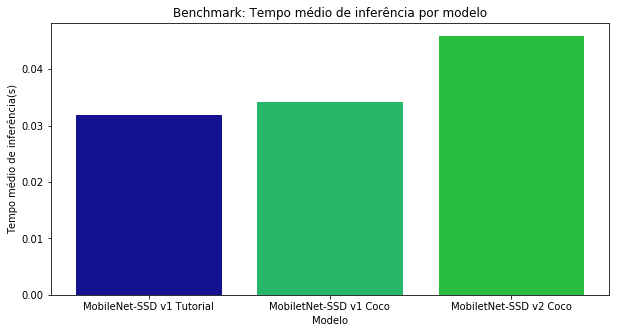

In [10]:
models = []
models.append({'id': 1, 'name':'MobileNet-SSD v1 Tutorial'})
models.append({'id': 2, 'name':'MobileNet-SSD v1 Coco'})
models.append({'id': 3, 'name':'MobileNet-SSD v2 Coco'})

def conf_inter(sample, interval):
    avg = np.average(sample)
    std = st.sem(sample)
    conf = st.norm.interval(interval, loc=np.average(sample), scale=st.sem(sample)/math.sqrt(len(sample)))
    return conf

def collect_metrics(files):
    files.sort()
    metrics = np.zeros(shape=(len(files), 4))

    for i, file in enumerate(files):
        with open(file,'r') as f:
            data = f.read()
            measurements = np.array(data.split('\n'))
            measurements = measurements[measurements != ''].astype(np.float32)
            avg = np.average(measurements)
            std = st.sem(measurements)
            conf = conf_inter(measurements, 0.95)
            metrics[i,:] = [avg, std, conf[0], conf[1]]
    return metrics


def plot_time_bars(models, averages, errors, colors=None):
    names = [param['name'] for param in models]
    
    fig, axis = plt.subplots(1, 1, figsize=(10, 5))
    axis.set_title('Benchmark: Tempo médio de inferência por modelo')
    axis.set_ylabel('Tempo médio de inferência(s)')
    axis.set_xlabel('Modelo')
    bars = axis.bar(names, averages, yerr=errors)
    if(colors == None):
        for bar in bars:
            color = np.random.rand(3)
            print(color)
            bar.set_color(color)
    else:
        for bar, color in zip(bars, colors):
            bar.set_color(color)

    if(os.path.exists('charts/bar.png')):
        os.remove('charts/bar.png')
    plt.savefig('charts/bar.png')

test_name = 'dataset'
files = ['benchmark/time_{}_{}.dat'.format(param['name'], test_name) for param in models]

metrics = collect_metrics(files)
averages = metrics[:,0]
stds = metrics[:, 1]
errors = averages-metrics[:,2]

plot_time_bars(models, averages, errors)


In [18]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

annotations = './dataset/val2017/annotations/instances_val2017.json'
annotation_types = ['bbox']
coco_gt = COCO(annotations)

for model in models:
    test_file = 'benchmark/detections_{}_{}.json'.format(model['name'],test_name)
    print('\n\nCurrent file under testing', test_file)
    dataset = coco_gt.loadRes(test_file)
    coco_eval = COCOeval(coco_gt, dataset, annotation_types[0])
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    model['results'] = coco_eval.stats

loading annotations into memory...
Done (t=0.44s)
creating index...
index created!


Current file under testing benchmark/detections_MobileNet-SSD v1 Tutorial_dataset.json
Loading and preparing results...
DONE (t=0.06s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=11.78s).
Accumulating evaluation results...
DONE (t=2.19s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.012
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.006
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all

In [19]:
print([param['results'] for param in models])

[array([0.00557092, 0.00767817, 0.0060761 , 0.        , 0.00159993,
       0.01226696, 0.00577825, 0.00630042, 0.00630042, 0.        ,
       0.00192573, 0.01420568]), array([0.24433666, 0.37940459, 0.26433519, 0.02167091, 0.18894423,
       0.54502774, 0.21936043, 0.28558775, 0.28794153, 0.02917853,
       0.22897877, 0.6347224 ]), array([0.25943344, 0.40251302, 0.28046741, 0.02539463, 0.19832845,
       0.58263961, 0.23095174, 0.29825296, 0.30082644, 0.03525829,
       0.24144187, 0.66144565])]


<h2>Introdução</h2>
<p>A expansão da utilização e poder computacional de dispositivos móveis, aliados à crescente demanda por aplicações sofisticadas destinadas a estas plataformas, provocou a ampliação do interesse em estudo e pesquisa sobre visão computacional (EXPLICAR MELHOR?). Neste contexto, as últimas décadas resultaram em significativos avanços na disciplina, aproveitando-se sobretudo no progresso concomitante em inteligência artificial e aprendizado de máquina. Isto conferiu à visão computacional a flexibilidade proporcionada pelo uso de sistemas especialistas, sobretudo quando comparados com as tradicionais abordagens baseadas na detecção de formas paramétricas como a Transformada de Hough.</p>
<p>Desta forma, este trabalho foi concebido com o propósito de realizar a comparação quantitativa de modelos de aprendizado de máquina voltados à detecção de objetos em imagens. Houve interesse, sobretudo, em estudar a aplicabilidade destes modelos a circunstâncias que imponham limitações ao hardware utilizado, como em computadores pessoais de baixo custo.</p>
<p>Além disso, buscou-se estudar as métricas que são empregadas na avaliação da precisão de modelos de detecção de objetos na academia e na indústria. Isto foi feito com o intuito de providenciar informações dentro de um molde padrão que pode ser rapidamente compreendido, além de permitir a comparação dos resultados obtidos com referências fornecidas por trabalhos anteriores. </p>

<h2>Metodologia</h2>

<p>Para realização dos testes, foram selecionados modelos de visão computacional baseados em técnicas de Deep Learning, notórios por apresentar severas exigências de capacidade computacional. Dada a intenção deste trabalho de explorar a viabilidade da tecnologia em plataformas de baixo desempenho, os modelos escolhidos deveriam se propor a atingir menor tempo de inferência. Neste estudo foram selecionados, portanto, os modelos (a,b,c) baseados nas arquiteturas (d,e,f), que tomam proveito de técnicas (g,h,i), que visam obter maior desempenho computacional ao custo de redução da precisão das detecções.</p>

<p>Vale notar que, tratando-se de modelos de detecção de objetos, a saída destes modelos deve conter, para cada imagem (identificada por um número único no dataset), uma associação entre uma categoria (ou "classe" do objeto) e uma bounding box, que consiste de uma tupla informando as coordenadas do vértice superior esquerdo, junto com a largura e altura da imagem.</p>

<p>A utilização dos modelos foi feita por meio da interface na linguagem Python da biblioteca OpenCV. Isto se deve ao fato de oferecer um extenso conjunto de ferramentas de processamento de imagens e vídeos, eliminando atrasos com tarefas acessórias ao objetivo do trabalho. Adicionalmente, oferece acesso conveniente a funcionalidades que permitem o carregamento e uso de modelos criados e treinados em plataformas externas, como Caffe e Tensorflow, por meio do módulo DNN.</p>

<p>A medição do tempo de inferência foi feita por meio do uso destes modelos em captura de vídeo e imagens. No caso do vídeo, cada quadro é tratado como uma imagem independente, que é então submetida ao modelo de forma cronometrada. A medição é realizada (5000?) vezes, seguida pelo cálculo da média com intervalo de confiança de 95%. </p>

<p>As medidas de precisão empregadas, por sua vez, tiveram como referência aquelas avaliadas pelo dataset COCO (Common Objects in Context). Este é utilizado em pesquisas e competições que exploram o estado da arte em atividades de detecção de objetos, keypoints, captioning e segmentação. Para a finalidade de detecção de objetos, foi utilizado o dataset de validação de 2017, estando as imagens contidas no dataset "2017 Val Images" e o ground truth em "2017 Train/Val annotations". Este conjunto é composto de 5000 imagens e utiliza o formato JSON para representar o ground truth, de acordo com o seguinte formato:</p>

FORMATO DO JSON

<p>Junto ao dataset, é fornecida pelos autores do conjunto a ferramenta COCOeval, que utiliza a saída dos modelos (que deve ser disponibilizada no formato JSON, semelhante ao do ground truth) e realiza automaticamente a comparação das inferências com o ground truth do dataset. Esta resulta nas métricas sugeridas pelos autores do dataset, isto é, average precision (AP) e average recall (AR) utilizando intersection over union (IoU). O IoU consiste, essencialmente, em computar a razão com que a imagem predita e o ground truth se sobrepõem, resultando em um valor entre 0 e 1 ,que é mais alto quanto mais as duas imagens se sobrepõem. O AP e o AR são calculados sucessivamente, primeiro separadamente para cada tamanho de imagem (e.g., AP small, AP medium, AP large) e, em seguida, para todas as imagens, independentemente do tamanho.</p>

<h2>Resultados</h2>

<h2>Conclusão</h2>